In [0]:
# !nvidia-smi

In [0]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 5.1MB/s 
     |████████████████████████████████| 1.0MB 24.6MB/s 
     |████████████████████████████████| 3.8MB 44.8MB/s 
     |████████████████████████████████| 890kB 58.2MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/124-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [0]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_3.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_4.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/fold_5.tar.gz'

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/y_valid.npy
fold_4/x_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/y_valid.npy
fold_5/x_valid.npy


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 64,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


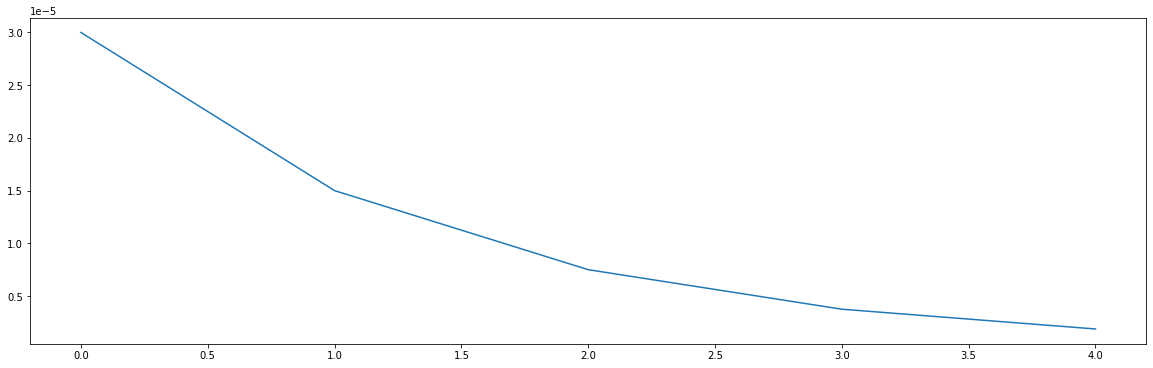

In [0]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [17]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    model.load_weights(MODEL_BASE_PATH + model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 2
Train for 343 steps, validate for 85 steps

EPOCH 1/5
time: 257.5s loss: 4.5316 loss_start: 2.2443 loss_end: 2.2873 val_loss: 2.0964 val_loss_start: 1.0470 val_loss_end: 1.0494
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/124-roBERTa_base/model_fold_2.h5"

EPOCH 2/5
time: 247.4s loss: 4.0274 loss_start: 2.0250 loss_end: 2.0024 val_loss: 1.9552 val_loss_start: 0.9908 val_loss_end: 0.9644
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/124-roBERTa_base/model_fold_2.h5"

EPOCH 3/5
time: 250.0s loss: 3.9340 loss_start: 1.9796 loss_end: 1.9544 val_loss: 1.9970 val_loss_start: 1.0308 val_loss_end: 0.9662
Epoch 00003: early stopping

FOLD: 3
Train for 343 steps, validate for 85 steps

EPOCH 1/5
time: 257.8s loss: 4.5369 loss_start: 2.2564 loss_end: 2.2805 val_loss: 2.0060 val_loss_start: 0.9990 val_loss_end: 1.0071
Saved model weights at "/content/drive/My Drive/Colab No

# Model loss graph

Fold: 1


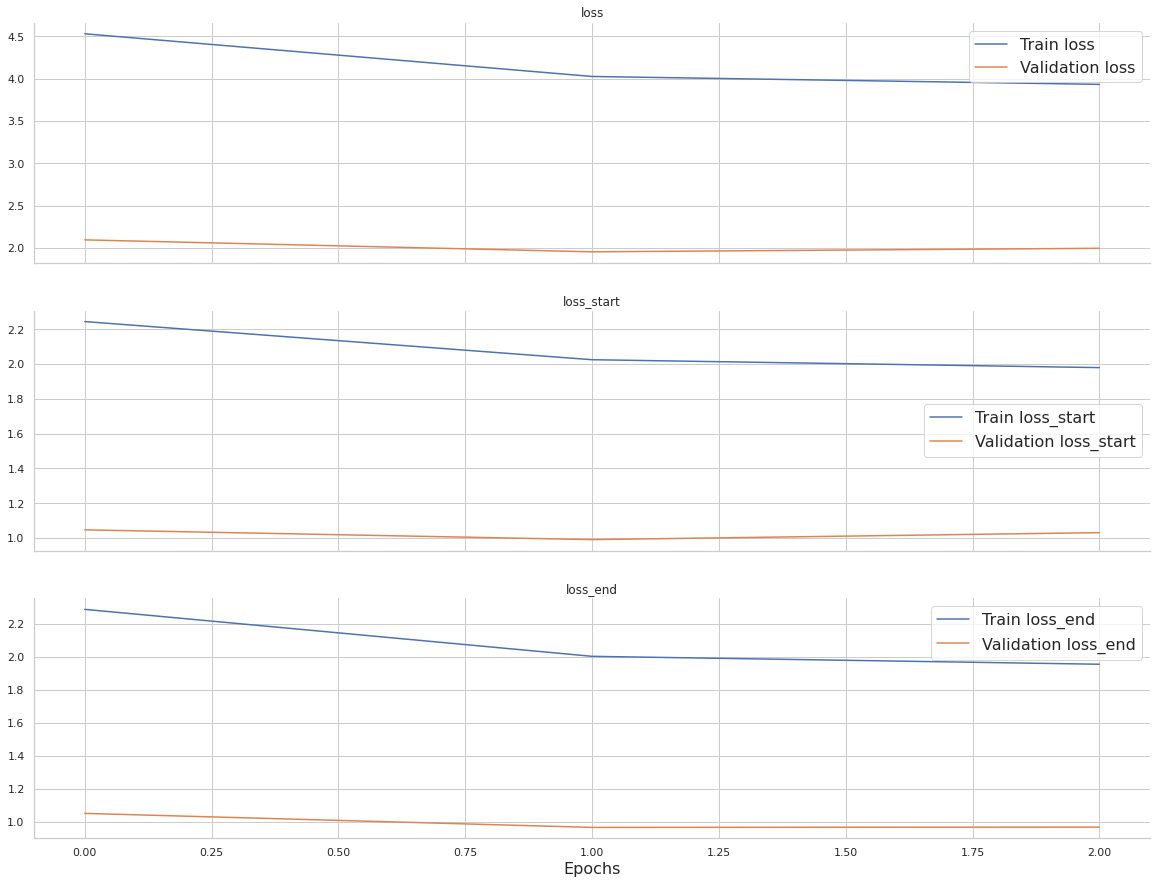

Fold: 2


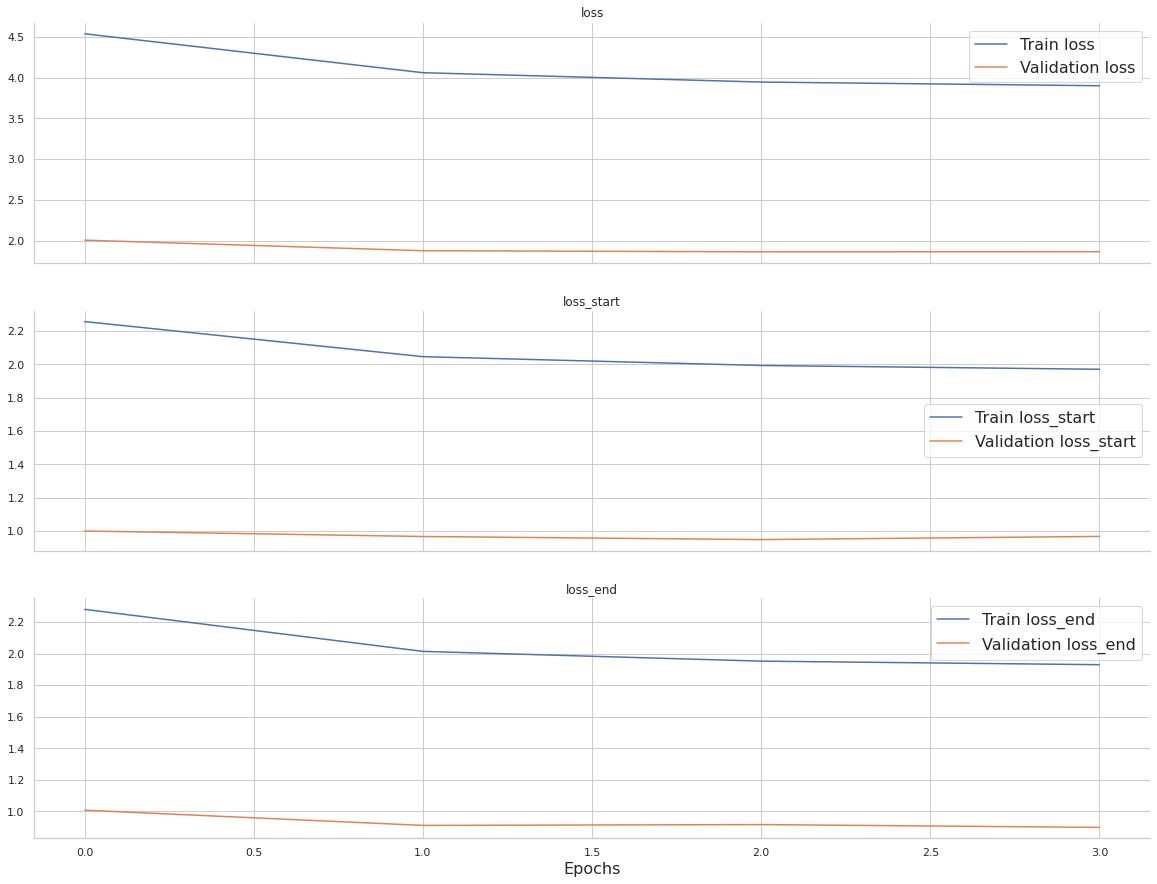

Fold: 3


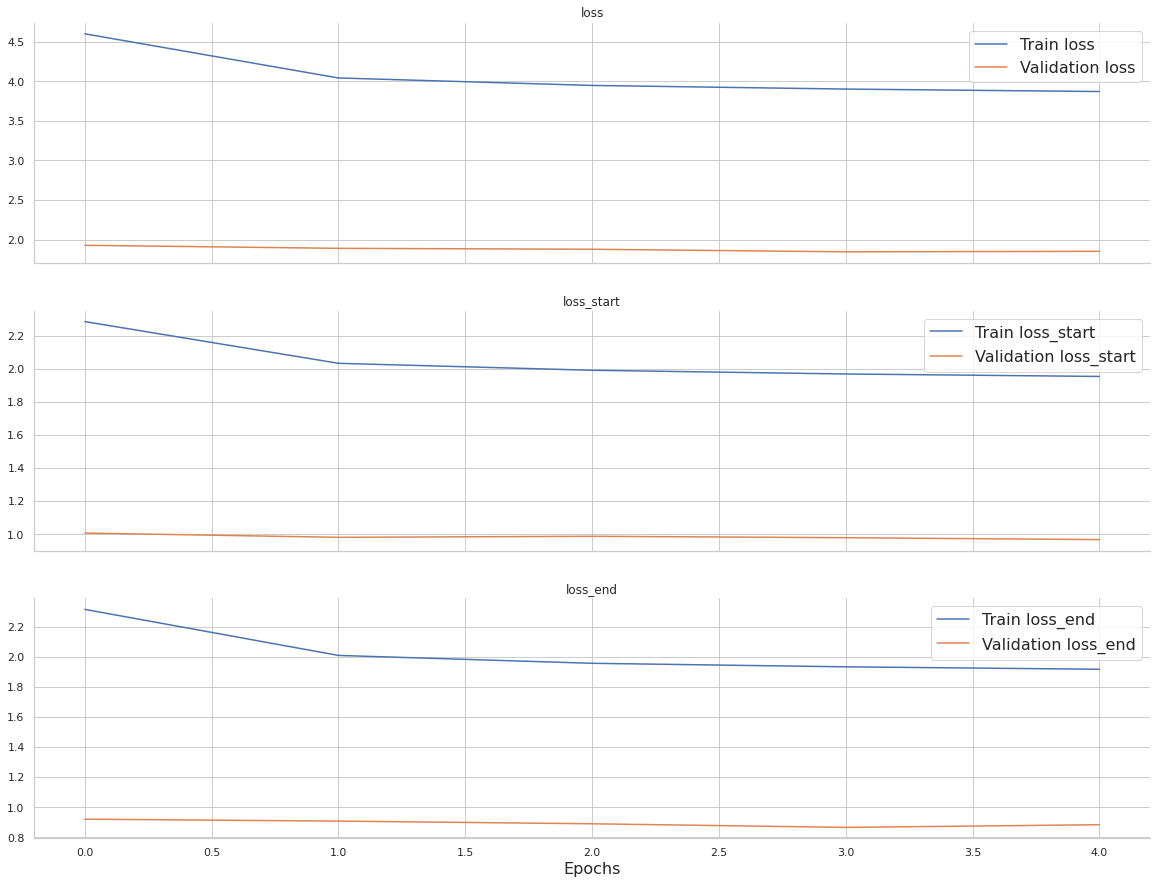

Fold: 4


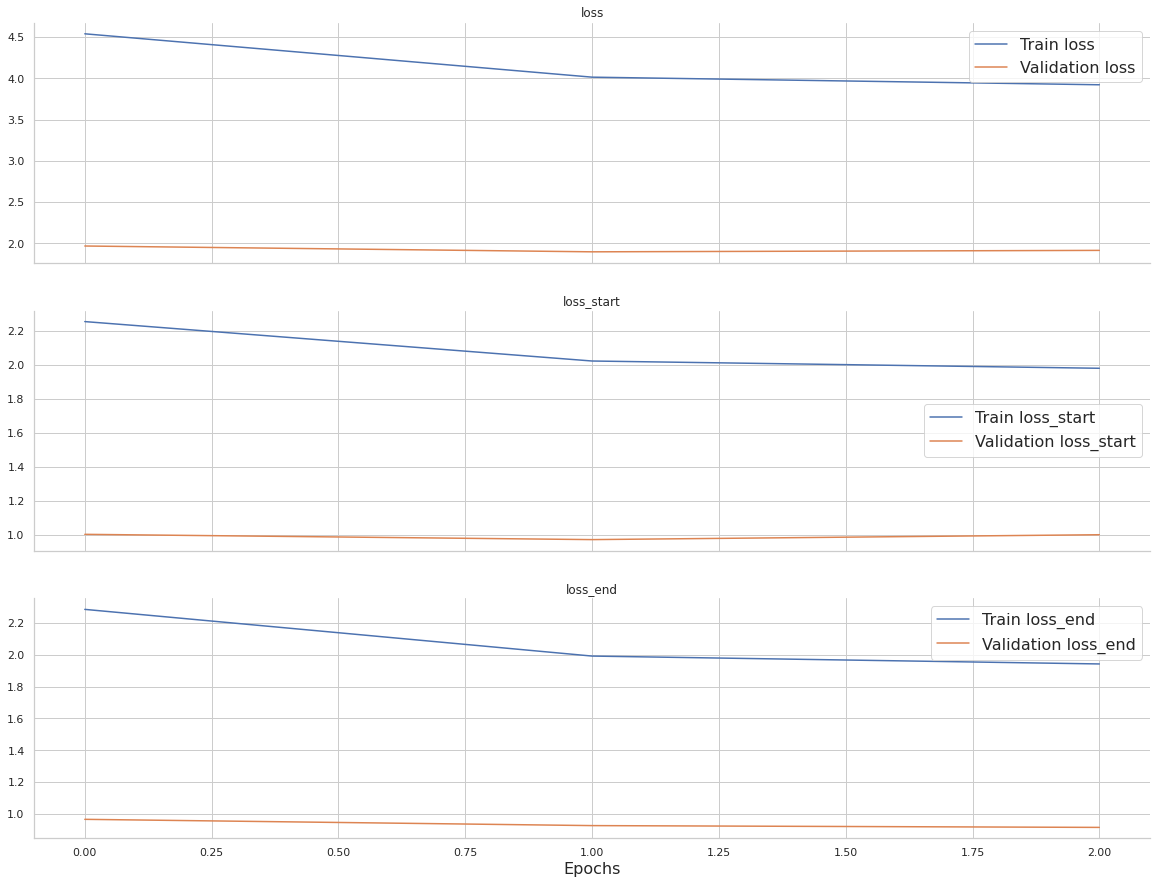

Fold: 5


IndexError: ignored

In [18]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [19]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.738116,0.704675,0.033442,0.752315,0.709946,0.730749,0.697342,0.733883,0.706845,0.746267,0.702802,0.727369,0.706438
Sentiment negative,0.581312,0.523297,0.058015,0.608863,0.524565,0.566161,0.514268,0.576488,0.529206,0.593178,0.528513,0.561867,0.519932
Sentiment neutral,0.974145,0.972862,0.001283,0.974813,0.973746,0.972999,0.972064,0.973577,0.973805,0.975484,0.971216,0.973851,0.973477
Sentiment positive,0.574538,0.521717,0.052821,0.594188,0.536146,0.566203,0.507296,0.566068,0.522190,0.588121,0.513232,0.558108,0.529721
0 <= text wordCnt < 3,0.852881,0.849608,0.003273,0.866550,0.824627,0.828529,0.832230,0.852044,0.864829,0.865758,0.838675,0.851526,0.887681
3 <= text wordCnt < 10,0.791604,0.766979,0.024625,0.803574,0.757322,0.785928,0.768205,0.787202,0.770557,0.797160,0.763163,0.784157,0.775650
10 <= text wordCnt < 30,0.705699,0.666586,0.039114,0.721202,0.679280,0.697681,0.658174,0.700861,0.669150,0.715469,0.664981,0.693284,0.661345
30 <= text wordCnt < 100,0.664857,0.618768,0.046089,0.687260,0.716336,0.681945,0.448815,0.684296,0.587113,0.663574,0.560369,0.607211,0.781207
0 <= selected text wordCnt < 3,0.676596,0.617610,0.058986,0.700351,0.620812,0.693969,0.634811,0.644537,0.589928,0.710725,0.635828,0.633398,0.606672


# Visualize predictions

In [20]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000
